# Hand Written Digit Recognition with CNN using Pytorch

### Author: Ahmed Hamza Bin Asif

#### Language: Python
#### Framework: Pytorch
#### Libraries: Numpy, Matplotlib
#### CPU: AMD Ryzen 5 3600
#### GPU: Nvidia GTX 1660 Super


### Step 0: Import Required Libraries

In [1]:
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Step 1: Data Transformation

In [2]:
# transform.ToTensor() to convert images into numbers and seperate the images into three(red, green, blue) channels
# transform.Normalise() to normalise the dataset along its mean and standard deviation
# torchvision.transforms.compose() to convert the output of above two functions into torch tensors
 
transform = torchvision.transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)),])

### Step 2: Data Collection

In [3]:
# download the dataset using torchvision.datasets.MNIST() into train and test sets
# apply the transformations to the data

trainSet = torchvision.datasets.MNIST('data', train = True, download = True, transform = transform)
testSet = torchvision.datasets.MNIST('data', train = False, download = True, transform = transform)

### Step 3: Data Loading

In [4]:
# Load the dataset into train and test set using Pytorch Dataloader
# Set the batch size to 128 for better performance
# Shuffle the dataset so that the data doesn't depend on the order
# train and test loader will be torch tensors that will contain the Image and its Label

trainLoader = torch.utils.data.DataLoader(trainSet, batch_size = 128, shuffle = True)
testLoader = torch.utils.data.DataLoader(testSet, batch_size = 128, shuffle = True)

### Step 4: Data Visulaization

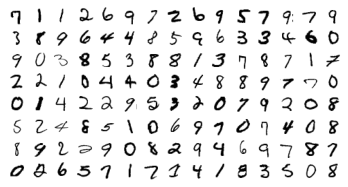

In [5]:
# iter() to create an iterator object. The object will be the training set.
# next() will be used on the iter() object to get iterate through the pictures
# img will contain the image and lbl will contain the label for that image
# use matplotlib functions to create a plot to display 120 images
# numpy.squeeze() to remove unnecessary one-dimensional entries

img, lbl = next(iter(trainLoader))
#print(type(img))
#print(type(lbl))
fig = plt.figure()
n_img = 120
for i in range(1, n_img + 1):
    plt.subplot(10, 15, i)
    plt.axis('off')
    plt.imshow(img[i].numpy().squeeze(), cmap='gray_r')

### Step 5: Convolutional NeuralNet Building

In [44]:

class ConvNet(nn.Module):    
    # Contructor
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [45]:
# This part will initialize the above convNet
# The model will be intialized and will be transferred to Cuda which simply means that all of the model training and testing
# will be performed on the GPU instead of CPU for better performance 
# CUDA toolkit will be used to use the GPU 

# Initializer
device = torch.device("cuda")
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Step 6 : Hyperparameters

In [46]:
# The dataset will be iterated through 10 times during model training in order to get better performance so Epoch will be 10
# Learning rate is the rate at which our Model will perform Gradient Descent to converge to the Global Minimum
# torch.optim.Adam - Adam Optimizer will be used as the Optimizer of this model
# Loss Function is the CrossEntropyLoss

epochs = 10
learning_rate = 0.01
lossFunc = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())

### Step 7: Model Training

In [47]:
# import tqdm library to give the model trainig a clean look
# model train function will take neural network model, device(GPU), training set, optimizer function and number of epoch as 
# input parameters
# Every pytorch neural net is initialized to .train() by default so that function will be called first
# Python enumerate() function will be used to add a counter to the training set images
# In every iteration of the loop the following steps will be performed: 
# 1. One image and its label will be taken from the training set and sent to the GPU which will later gets processed by the 
# neural net 
# 2. The optimizer function will set the gradients to zero after every iteration so that the gradient descent will start from
# zero after every iteration
# 3. Torch Negative Log Likelihood Loss function will take the log softmax output(Predicted label) of the model and the 
# correct label and calculate the loss if the model predicted didn't predict accurately.
# 4. loss.backward() will be used to compute the gradient loss and Backpropagation to update the parameters of the activation
# functions. This is the most important part of the neural network
# After every epoch, model loss will be shown.

from tqdm import tqdm
def modelTrain(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'epoch: {epoch} loss={loss.item()} batch_id={batch_idx}')

In [48]:
# Train the model for 20 epochs

for epoch in range(1, epochs+1):
    modelTrain(model, device, trainLoader, optimizer, epoch)
    #modelTest(model, device, testLoader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]<ipython-input-44-1750a71a8c1c>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
epoch: 10 loss=0.25134339928627014 batch_id=468: 100%|███████████████████████████████| 469/469 [00:06<00:00, 69.23it/s]


### Step 8: Model Testing

In [49]:
# modeltest() function will take the neural net, device(GPU) and tests set as input parameters
# model.eval() will be called for model evaluation
# Two variables will be initialized to calculate the loss and accuracy for the test set 
# Following steps will be performed during model testing:
# 1. Gradient will be initialized to zero
# 2. In every iteration of the test data, one image and its label will taken for testing
# 3. Image will be given to the learned model for testing
# 4. Negative Log Likelihood Loss function will be used to compute the loss for the image
# 5. np.argmax() will be used to get the indices of the maximum probability tensor
# 6. Model accuracy will be calculated after summing up the tensor values and getting the element-wise equality using
# pytorch.eq() function
# 7. After complete testing the Average loss will be calculated by dividing the total loss with total number of images 
# in the dataset.
# Average Loss and model accuracy will be shown as the final output for the function

def modelTest(model, device, testLoader):
    #model = Net()
    #model.load_state_dict(torch.load(PATH))
    model.eval()
    testLoss = 0
    accurate = 0
    with torch.no_grad():
        for data, target in testLoader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #print(type(output))
            testLoss += F.nll_loss(output, target).item()
            #print(type(testLoss))
            predict = output.argmax(dim = 1, keepdim = True)
            #print(type(predict))
            accurate += predict.eq(target.view_as(predict)).sum().item()
            #print(type(accurate))
            
    testLoss /= len(testLoader.dataset)
    
    print('\nTest set') 
    print("Images Tested: {}".format(len(testLoader.dataset)))
    print('Average loss: {:.4f} \nAccuracy: {}/{} => ({:.1f}%)\n'.format(
        testLoss, accurate, len(testLoader.dataset),
        100 * (accurate / len(testLoader.dataset))))

In [50]:
modelTest(model, device, testLoader)

<ipython-input-44-1750a71a8c1c>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set
Images Tested: 10000
Average loss: 0.0003 
Accuracy: 9880/10000 => (98.8%)



### Step 9: Model Prediction

[3.207295e-08, 1.513628e-10, 8.2853967e-07, 8.9019557e-07, 3.0373727e-14, 7.452975e-08, 6.163373e-08, 3.5929487e-10, 0.9999982, 1.5007709e-08]
Predicted Digit = 8
<class 'numpy.ndarray'>


<ipython-input-44-1750a71a8c1c>:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


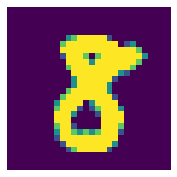

In [54]:
# In this stage the model will predict the label(number) with maximum probability
# All the images are in CUDA Tensor format so first they will be converted into numpy format and furthur the outputs will
# use np.squeeze to remove one-dimensional entries
# To do that var.cpu().data.numpy().squeeze() will be used
# The target label will be shown on the left
# A graph for probablities from 0.0 - 1.0 for 0-9 numbers will be generated on the right
# next(iter(testlodaer)) will be used to get images and an iterator from the testset
# The image will be converted to a CUDA Tensor and given to the Model for prediction
# Neural Net will give the log probabilities as an output in a CUDA Tensor format
# The CUDA Tensor will be converted into numpy format and then into a list
# Get the index with the maximum probability from the list. The index number will be the predicted Digit

def predictDigit(img, ps):
    cudaToNp = ps.cpu().data.numpy().squeeze()
    print(type(cudaToNp))
    #plt.subplots will be used to plot two plots side by side
    fig, (ax1) = plt.subplots(figsize=(3,3))
    #images will be resized into 28*28 pixels into its original form
    ax1.imshow(img.resize(28, 28).numpy().squeeze())
    #axis will be off to remove number outlines from image plot
    ax1.axis('off')


img, lbl = next(iter(testLoader))
with torch.no_grad():
    numProb = model(img.cuda())

ps = torch.exp(numProb)
probab = list(ps.cpu().numpy()[0])
print(probab)
print("Predicted Digit =", probab.index(max(probab)))
img = img[0].view(1, 784)
predictDigit(img, ps)



### Step 10: Save Model

In [55]:
PATH = os.getcwd()
torch.save(model.state_dict(), os.path.join(PATH,"Model.pt"))

### References:
#### https://medium.com/@ankitbatra2202/mnist-handwritten-digit-recognition-with-pytorch-cce6a33cd1c1
#### https://medium.com/@ravivaishnav20/handwritten-digit-recognition-using-pytorch-get-99-5-accuracy-in-20-k-parameters-bcb0a2bdfa09
#### https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
#### https://github.com/yrowe/Digit-Recognizer-with-pytorch/blob/master/digit_recognizer.ipynb
#### https://www.pluralsight.com/guides/building-your-first-pytorch-solution
#### https://nextjournal.com/gkoehler/pytorch-mnist